In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Read the CSV file
data = pd.read_csv("train.csv")

# Iterate over each row in the DataFrame
for index, row in data.iterrows():
    image_name = row['image_name'] + '.jpg'  # Add '.jpg' extension
    diagnosis = row['diagnosis']
    
    # Skip files without a diagnosis
    if pd.isna(diagnosis):
        print(f"Skipping file without a diagnosis: {image_name}")
        continue
    
    # Construct the old and new file paths
    old_path = os.path.join("C:/Developer/Cancer/train", image_name).replace("\\", "/")
    new_path = os.path.join("C:/Developer/Cancer/train", f"{diagnosis}_{image_name}").replace("\\", "/")
    
   
    
    # Check if the old file exists
    if os.path.exists(old_path):
        # Rename the file
        os.rename(old_path, new_path)

print("All files in the train directory renamed successfully.")


All files in the train directory renamed successfully.


In [2]:
#drop id column
data = data.drop('patient_id', axis=1)
data_noimage = data.drop('image_name', axis=1)

In [3]:
#encode data_noimage using label encoder
le = LabelEncoder()

for col in data_noimage.columns:
    if data_noimage[col].dtype == 'object':
        data_noimage[col] = le.fit_transform(data_noimage[col])

data_noimage.dropna(inplace=True)

In [4]:
#make a model predicting the diagnosis in data_noimage 
X = data_noimage.drop('diagnosis', axis=1)
y = data_noimage['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8330308529945554


In [5]:
#get better params using a griud search and predict again
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
print(accuracy_score(y_test, y_pred))

Fitting 3 folds for each of 9 candidates, totalling 27 fits


c:\Users\rapha\anaconda3\envs\basePython\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


{'max_depth': 10, 'n_estimators': 100}
0.8330308529945554


In [6]:
from PIL import Image
import os
import pandas as pd

# Read the CSV file
data = pd.read_csv("train.csv")

# Initialize empty lists to store images and labels
images = []
labels = []

# Iterate over each row in the DataFrame
for index, row in data.iterrows():
    image_name = row['image_name'] + '.jpg'  # Add '.jpg' extension
    diagnosis = row['diagnosis']
    
    # Skip files without a named label or with label 'unknown'
    if pd.isna(diagnosis) or diagnosis == 'unknown':
        continue
    
    # Construct the file path
    file_path = os.path.join("C:/Developer/Cancer/train", diagnosis, image_name)
    
    # Check if the file exists
    if os.path.exists(file_path):
        # Load the image
        image = Image.open(file_path)
        
        # Append the image and label to the lists
        images.append(image)
        labels.append(diagnosis)
    else:
        print(f"File not found: {file_path}")



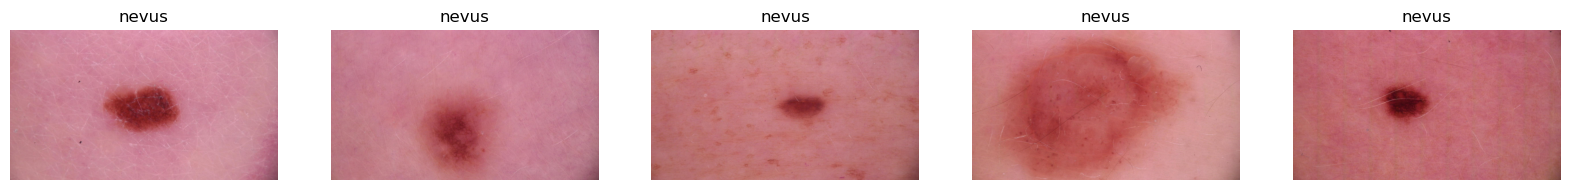

In [7]:
#print few images from image with their label 
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i in range(5):
    axes[i].imshow(images[i])
    axes[i].set_title(labels[i])
    axes[i].axis('off')

plt.show()

In [8]:
print(len(images))

6002


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Define the neural network model
class DiagnosisModel(nn.Module):
    def __init__(self):
        super(DiagnosisModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Define a custom dataset
class DiagnosisDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Preprocess the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create the dataset and dataloader
dataset = DiagnosisDataset(data, labels, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Create an instance of the model
model = DiagnosisModel()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}")

# Save the trained model
torch.save(model.state_dict(), 'diagnosis_model.pth')

KeyError: 7218